# Define the libraries

In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import timedelta
from scipy import signal
from scipy.stats import linregress

# Define Function

In [12]:
def PlotData(Begin,Duration,Mistake,OncourtFrame,OncourtVideo,Time,Data1,Data2,Data3,Data4,Figuur,player, timesInSeconds, StartTimes, StopTimes,pdf, Data5, ArrayStartCollision, ArrayStopCollision):
    Start = int((((OncourtFrame - OncourtVideo)*100) + Begin/10) - Mistake*100)
    Stop = int(Start + Duration*100)
    
    WheelRotationspeed = Data1[Start:Stop]
    FrameRotationspeed = Data2[Start:Stop]
    
    Timestamp = Time[Start:Stop]
    
    #Lowpass filter design for rotation and wheelspeed to improve accuracy of code (Butterworth filter)
    Order = 5 
    cutoff_freq = 1.5
    sampling_freq = 100
    sampling_duration = Duration
    
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    filtered_WheelRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, WheelRotationspeed)
    filtered_FrameRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, FrameRotationspeed)
    
    
    #Play with different operations to see clearer patterns
    Sub = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    Conv1 = filtered_FrameRotationspeed / filtered_WheelRotationspeed
    Conv2 = (abs(filtered_FrameRotationspeed)+abs(filtered_WheelRotationspeed))/filtered_WheelRotationspeed
    
    DiffFrame = np.diff(filtered_FrameRotationspeed,n=1)
    DiffFrame = np.insert(DiffFrame,0,0)
    
    DiffWheel = np.diff(filtered_WheelRotationspeed,n=1)
    DiffWheel = np.insert(DiffWheel,0,0)
    
    Multi = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    
    #Set all data into a datafram
    Data = pd.DataFrame({'Time':Timestamp,'WheelRotationspeed':filtered_WheelRotationspeed,
                         'FrameRotationspeed':filtered_FrameRotationspeed,
                         'Sub':Sub ,'Conv':Conv1, 'DiffFrame':DiffFrame, 'DiffWheel':DiffWheel, 'frameSpeed': Data5[Start:Stop]}, 
                        columns=['Time', 'WheelRotationspeed','FrameRotationspeed','Sub','Conv','DiffFrame','DiffWheel', 'frameSpeed'])
    
    #Convert data into chunks of n/100 of a second
    n = 50  #chunk row size
    Data_chunks = [Data[i:i+n] for i in range(0,Data.shape[0],n)]
    
  
    # collisions 
    
    #Search for the collisions
    Startcollision = []
    Stopcollision = []
    Collision = False
    End = True
    
    #Use frSpeed en FrameRotations to detect collisions
    for chunks in Data_chunks:
        if chunks['frameSpeed'].min() > 0.2 and chunks['frameSpeed'].iloc[0]/chunks['frameSpeed'].iloc[-1] < 0 and Collision == False:
            Startcollision.append(chunks['Time'].min())
            Collision = True
            End = False
        elif abs(chunks['frameSpeed'].min() < 0.2) and abs(chunks['FrameRotationspeed'].min() < 0.2):
            Stopcollision.append(chunks['Time'].min())
            Collision = False
            End = True
    
    fig, ax = plt.subplots(2)
    ax[0].plot(Time[Start:Stop],Data2[Start:Stop],'b',Time[Start:Stop],Data3[Start:Stop],'g')
        #Plot the vertical lines in plot 1
#    for Start in Startcollision:
 #       ax.axvline(x=Start, color = 'g')
  #  for Stop in Stopcollision:
   #     ax.axvline(x=Stop, color = 'r')
    ax[0].legend(['Frame Rotation Speed X', 'Frame Rotation Speed Y'])
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_title("Contact stopped " + str(Figuur+ 1) + ", " + str(player) + ", Video Time = " + str(timedelta(seconds=(int(Begin/1000)-Mistake))))

    ax[1].plot(Time[Start:Stop],Data1[Start:Stop],'r')
    ax[1].legend(['Wheel Rotation Speed X'])
    ax[1].set_xlabel('Time (sec)')
    
    
    ArrayStartCollision.append(Startcollision)
    ArrayStopCollision.append(Stopcollision)
    
    StartTimes.append(Start)
    StopTimes.append(Stop)
    pdf.savefig()

# Visualize Data
## Define player and match

In [13]:
Player = 15
Game = 2

## Insert Data player

In [14]:
df_Player = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '.csv')
df_Player.columns = ['frAcc','frRoAcc','frDispl','frRoAng','frSpeed','timeLine','frameRotationalSpeedX','frameRotationalSpeedY','frameRotationalSpeedZ','wheelRotationalSpeedX','wheelRotationalSpeedY','wheelRotationalSpeedZ','frRoSpeed']
df_Action = pd.read_csv('NED_DUI_Game_' + str(Game) + '.csv')
df_Player

,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed
0,0.000000,0.0,0.0,0.00000,0.000000,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,0.000000,0.0,0.0,0.00000,0.000000,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
2,0.000000,0.0,0.0,0.00000,0.000000,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
3,0.000000,0.0,0.0,0.00000,0.000000,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
4,0.000000,0.0,0.0,0.00000,0.000000,0.05,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
860405,-0.002098,6556.8,-1946.6,-0.18538,-0.000787,8604.10,1.0500,0.85556,-1.0500,1.4000,1.16670,-1.5867,-0.40135
860406,-0.026347,6556.8,-1946.6,-0.18939,-0.000808,8604.10,1.0920,0.93100,-1.0710,1.4000,1.09200,-1.6240,-5.03910
860407,0.012933,6556.8,-1946.6,-0.23979,-0.001071,8604.10,1.1690,0.95900,-1.1200,1.4000,1.08110,-1.5089,NaN
860408,NaN,NaN,NaN,NaN,NaN,NaN,1.1433,0.93333,-1.0967,1.4000,1.08500,-1.4700,NaN


In [15]:
print(df_Action)

               Name   Position  Duration Game time     Player  \
0      No clock (1)        0.0   49960.0  No clock        NaN   
1      On court (1)    48320.0    1000.0  No clock   On court   
2      On court (2)    48320.0    1000.0  No clock   On court   
3      On court (3)    48320.0    1000.0  No clock   On court   
4      On court (4)    48320.0    1000.0  No clock   On court   
..              ...        ...       ...       ...        ...   
804   On court (24)  2813800.0    1000.0       NaN   On court   
805  Off court (19)  3299600.0    1000.0       NaN  Off court   
806   On court (25)  4163840.0    1000.0       NaN   On court   
807  Off court (20)  2811520.0    1000.0       NaN  Off court   
808   On court (26)  2814360.0    1000.0       NaN   On court   

    Players Group Box Scoring  Unnamed: 7  Unnamed: 8  Unnamed: 9  
0                 NaN     NaN         NaN         NaN         NaN  
1            Player 2     NaN         NaN         NaN         NaN  
2           Pla

## Define boundaries
### Get Timestamps from CSV

In [16]:
df_Action_Player = df_Action.loc[df_Action["Players Group Box"] == ("Player " + str(Player))]
df_Events = df_Action_Player.query("Player == 'Contact stopped' or Player == 'Contact IS stopped'")
df_Action_Player_Collision = df_Events.iloc[::-1]
Timestamp = df_Action_Player_Collision.Position.to_numpy()
print(len(Timestamp))
Timestamp

19


array([3938600., 3896840., 3871720., 3752680., 3741840., 3721760.,
       3054400., 2861240., 2597600., 1997400., 1931520., 1681280.,
       1671360., 1583840., 1577400.,  793320.,  673720.,  511080.,
         83800.])

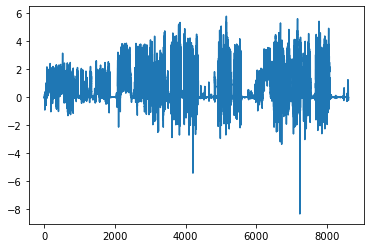

In [17]:
plt.plot(df_Player['timeLine'],df_Player['frSpeed'])
plt.show()

### Synchronize
Times consist of the oncourt times in the video and the oncourt frames in Matlab

In [18]:
Times = [
         [(23.8),2829.5],
         [((30*60)+6.88),4577.6],
         [((39*60)+51.76),6143.3],
         [((61*60)+57.40),7714.1]
        ]
Times[0][0]

23.8

In [19]:
Error = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
print(len(Error))

67


In [20]:
print(len(Timestamp))

19


### Visualize

In [21]:
pdf = PdfPages('Player_' + str(Player) + '_' + str(Game) + '_ContactStopped.pdf')

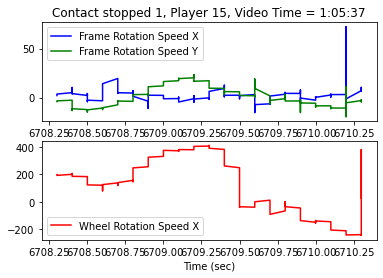

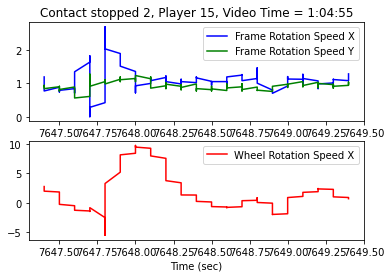

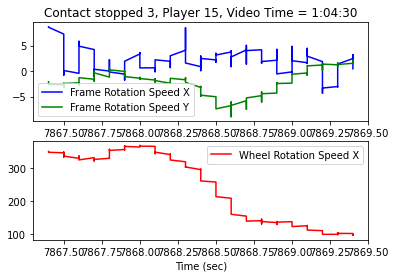

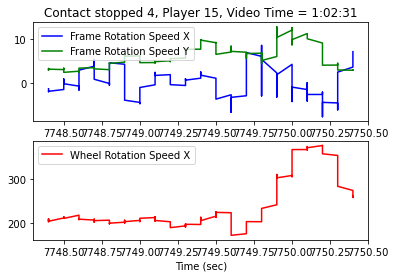

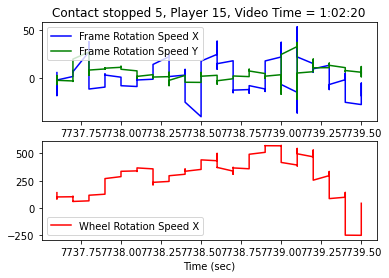

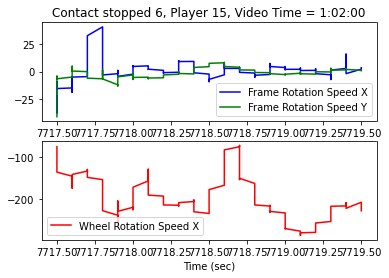

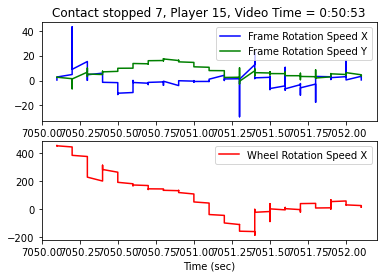

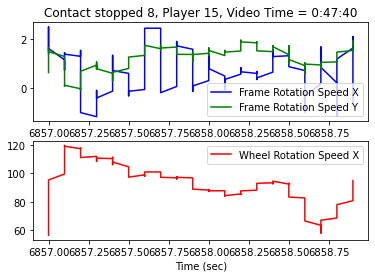

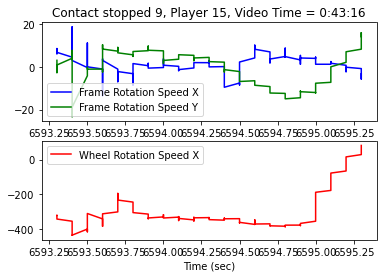

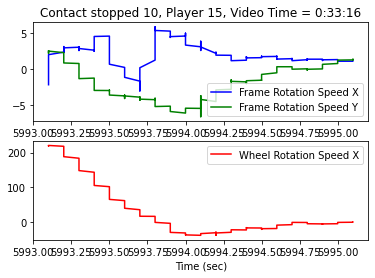

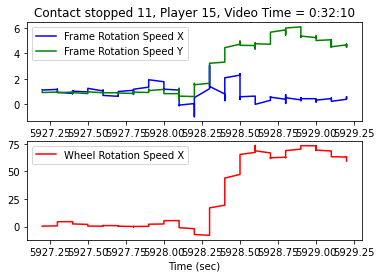

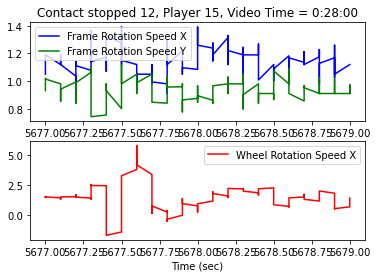

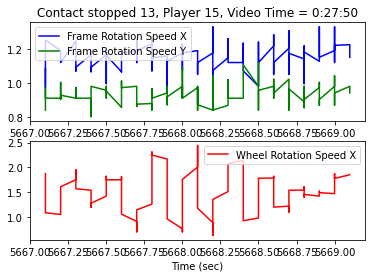

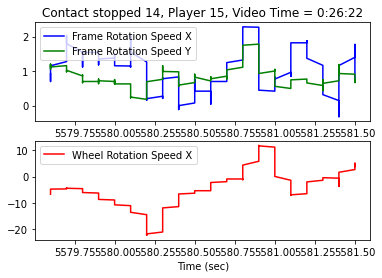

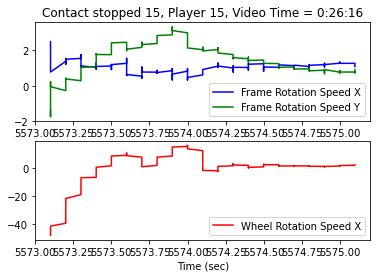

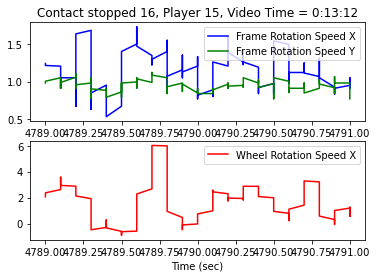

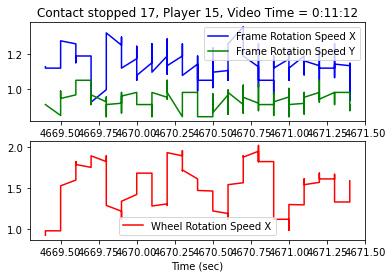

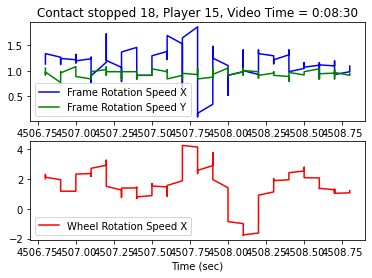

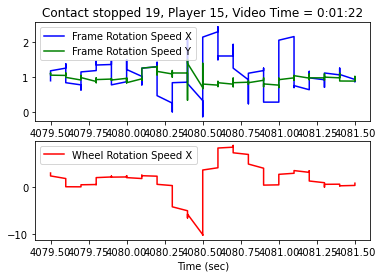

In [22]:
Quator = 0
timesInSeconds = []
StartTimes = []
StopTimes = []

ArrayStartCollision = []
ArrayStopCollision = []
for i in range(0,len(Timestamp)):
    if Quator < (len(Times)-1):
        if Timestamp[i] >= (Times[Quator+1][0] * 1000):
            Quator = Quator + 1
    PlotData(Timestamp[i], 2, Error[i], Times[Quator][1], Times[Quator][0], df_Player.timeLine.to_numpy(), 
             df_Player.wheelRotationalSpeedX.to_numpy(), 
             df_Player.frameRotationalSpeedX.to_numpy(),
             df_Player.frameRotationalSpeedY.to_numpy(),
             df_Player.frameRotationalSpeedZ.to_numpy(),
             i,('Player ' + str(Player)), timesInSeconds, StartTimes, StopTimes, pdf, df_Player.frSpeed.to_numpy(), ArrayStartCollision, ArrayStopCollision)

In [23]:
pdf.close()

In [24]:
print(len(StartTimes))
print(len(StopTimes))

19
19


In [25]:
df_Filter = df_Player
df_Filter = df_Filter.fillna(0)

Order = 5 
cutoff_freq = 1.5
sampling_freq = 100
sampling_duration = len(df_Filter.wheelRotationalSpeedX)/100

  
normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)

filtered_WheelRotationspeedX = signal.lfilter(numerator_coeffs, denominator_coeffs, df_Filter.wheelRotationalSpeedX)
filtered_FrameRotationspeedZ = signal.lfilter(numerator_coeffs, denominator_coeffs, df_Filter.frameRotationalSpeedZ)


df_Player['Sum_WheelX_FrameZ']  = df_Player.wheelRotationalSpeedX + df_Player.frameRotationalSpeedZ
df_Player['Div_FrameZ_WheelX']  = df_Player.frameRotationalSpeedZ / df_Player.wheelRotationalSpeedX
df_Player['Filt_WheelX'] = filtered_WheelRotationspeedX
df_Player['Filt_FrameZ'] = filtered_FrameRotationspeedZ

In [26]:
df_Player['Collision'] = 0
for i  in range(0,len(StartTimes)):
    df_Player['Collision'].iloc[int(StartTimes[i]):int(StopTimes[i])] = 1



/opt/jupyterhub/anaconda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
print(df_Player['Collision'].sum())

3800


In [28]:
df_Player.to_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action_Collision.csv')